In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import networkx as nx
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import RFE

import sys
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QHBoxLayout, QPushButton
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas


In [2]:
df = pd.read_csv("DelayedFlights.csv")
df = df.drop("Unnamed: 0", axis=1)

In [3]:
# print(df.head())
# print(df.describe())
# print(df.info())
print(df.columns)

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')


### Data Cleaning

In [4]:
# Total

missing_values_count = df.isnull().sum()
print(missing_values_count)

total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

# Ver los que tiene menos valores nulos
missing_values_count = df['AirTime'].isnull().sum()
print(missing_values_count)

total_cells = np.product(df['AirTime'].shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print('%',percent_missing)

# Ver los que tienen mayor valores nulos
missing_values_count = df[('CarrierDelay')].isnull().sum()
print(missing_values_count)

total_cells = np.product(df['CarrierDelay'].shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print('%',percent_missing)

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                7110
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   5
ActualElapsedTime      8387
CRSElapsedTime          198
AirTime                8387
ArrDelay               8387
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                 7110
TaxiOut                 455
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
dtype: int64
6.207296437904352
8387
% 0.4330432609546469
689270
% 35.588855189961784


In [5]:
# Imputar los valores faltantes con la media
df['ArrTime'].fillna(df['ArrTime'].mean(), inplace=True)
df['ActualElapsedTime'].fillna(df['ActualElapsedTime'].mean(), inplace=True)
df['CRSElapsedTime'].fillna(df['CRSElapsedTime'].mean(), inplace=True)
df['AirTime'].fillna(df['AirTime'].mean(), inplace=True)
df['ArrDelay'].fillna(df['ArrDelay'].mean(), inplace=True)
df['TaxiIn'].fillna(df['TaxiIn'].mean(), inplace=True)
df['TaxiOut'].fillna(df['TaxiOut'].mean(), inplace=True)

# Interpolacion
df['CarrierDelay']=df['CarrierDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation
df['WeatherDelay']=df['WeatherDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation
df['NASDelay']=df['NASDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation
df['SecurityDelay']=df['SecurityDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation
df['LateAircraftDelay']=df['LateAircraftDelay'].interpolate(method='linear',limit_direction ='both',axis=0) #Interploation

In [6]:
# Verificar si hay valores negativos
print(all(i < 0 for i in df['ArrTime']))
print(all(i < 0 for i in df['CRSArrTime']))
print(all(i < 0 for i in df['DepTime']))
print(all(i < 0 for i in df['CRSDepTime']))


False
False
False
False


In [7]:
df.rename(columns={'DayofMonth': 'Day'}, inplace=True)
df['FlightDate'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
# Crear una nueva variable de ruta de vuelo
df['FlightRoute'] = df['Origin'] + '-' + df['Dest']

In [8]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols

['Year',
 'Month',
 'Day',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'FlightNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

# EDA

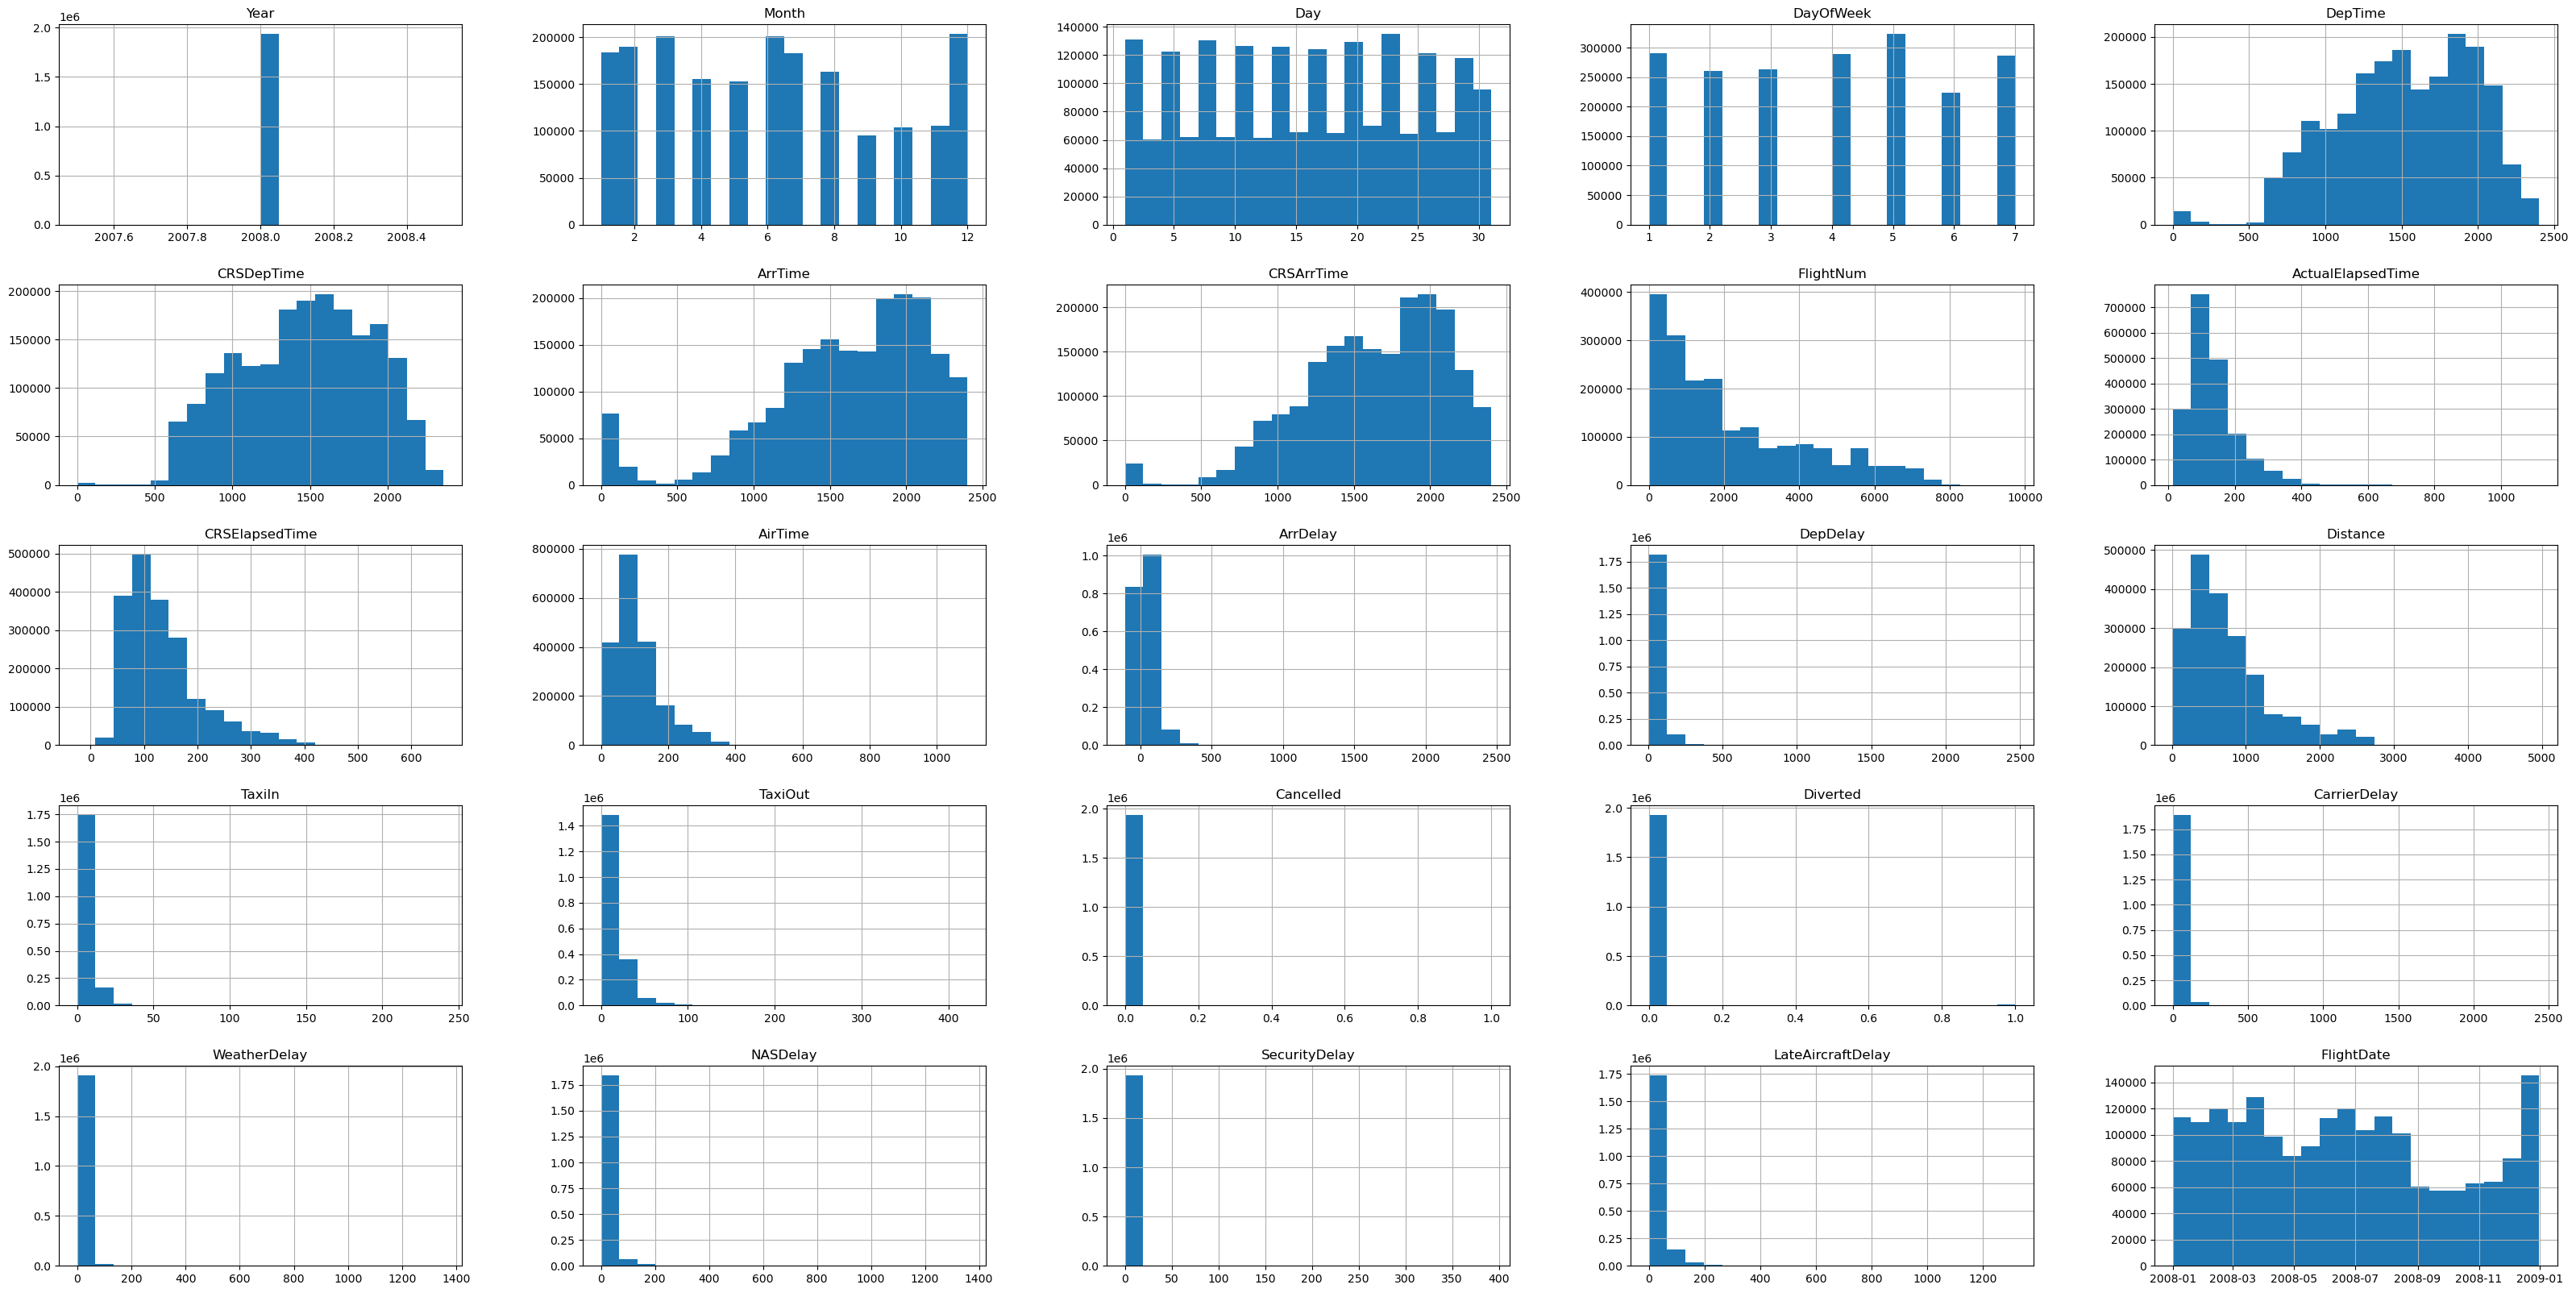

In [9]:
# Crear histogramas de las columnas numéricas
df.hist(bins=20, figsize=(40,20))
plt.show()

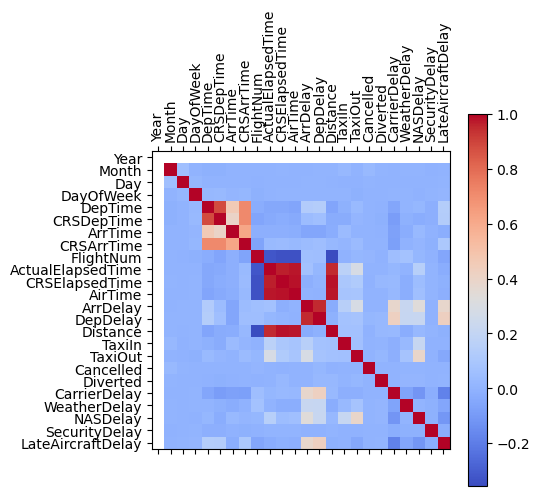

In [10]:
# Calcular la correlación entre las columnas numéricas
corr_matrix = df[numeric_cols].corr()
# Visualizar la matriz de correlación como un mapa de calor
plt.matshow(corr_matrix, cmap='coolwarm')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()
plt.show()

A través de la matriz de correlación podemos ver cómo algunas de las 29 variables del conjunto de datos presentan multicolinealidad, es decir, se pueden predecir linealmente a partir de las demás. Para tener un mejor análisis y trabajar con un conjunto de datos más ligero, vamos a eliminar algunas de esas variables no deseadas y crear otras nuevas.

<Axes: xlabel='Dest', ylabel='count'>

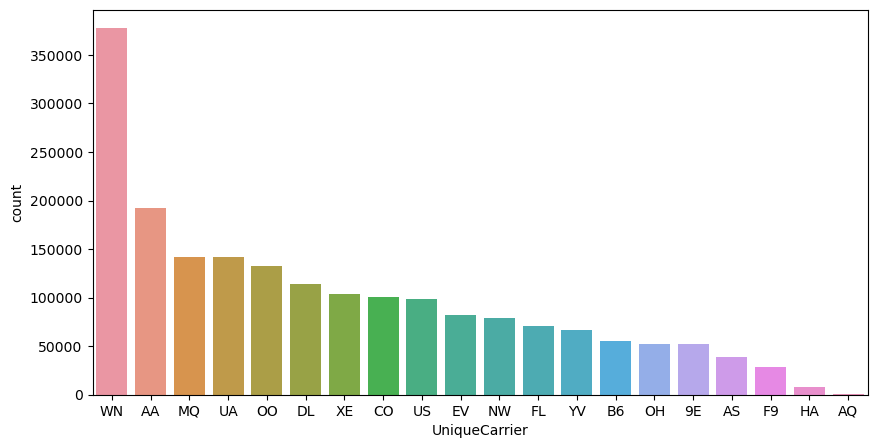

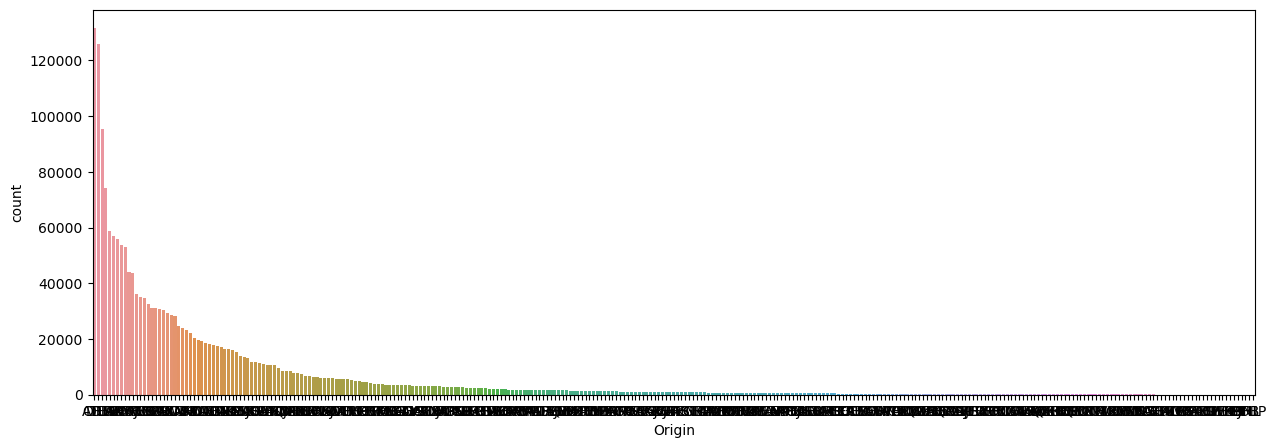

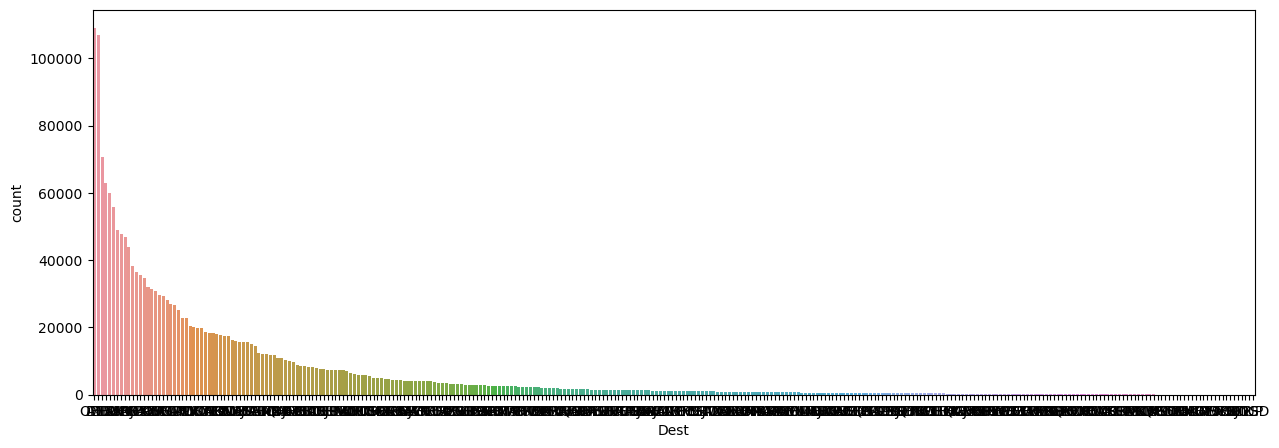

In [11]:
# análisis de la variable 'UniqueCarrier'
plt.figure(figsize=(10,5))
sns.countplot(x='UniqueCarrier', data=df, order=df['UniqueCarrier'].value_counts().index)

# análisis de la variable 'Origin'
plt.figure(figsize=(15,5))
sns.countplot(x='Origin', data=df, order=df['Origin'].value_counts().index)

# análisis de la variable 'Dest'
plt.figure(figsize=(15,5))
sns.countplot(x='Dest', data=df, order=df['Dest'].value_counts().index)


<Axes: xlabel='DayOfWeek', ylabel='DepDelay'>

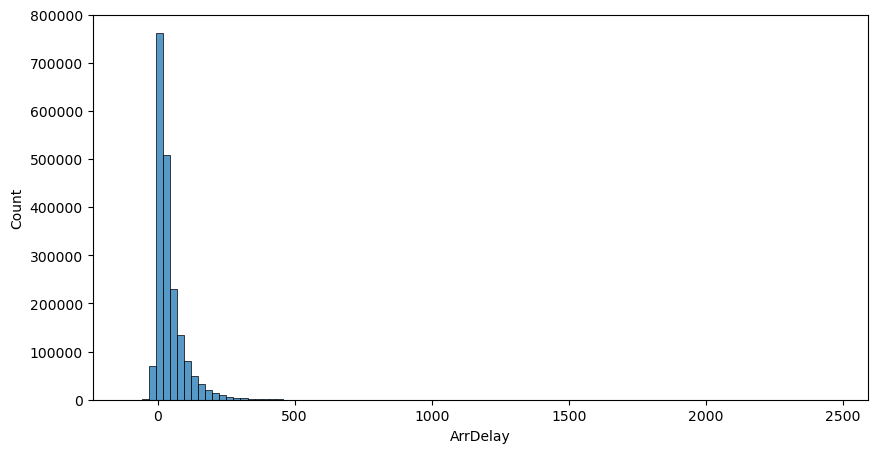

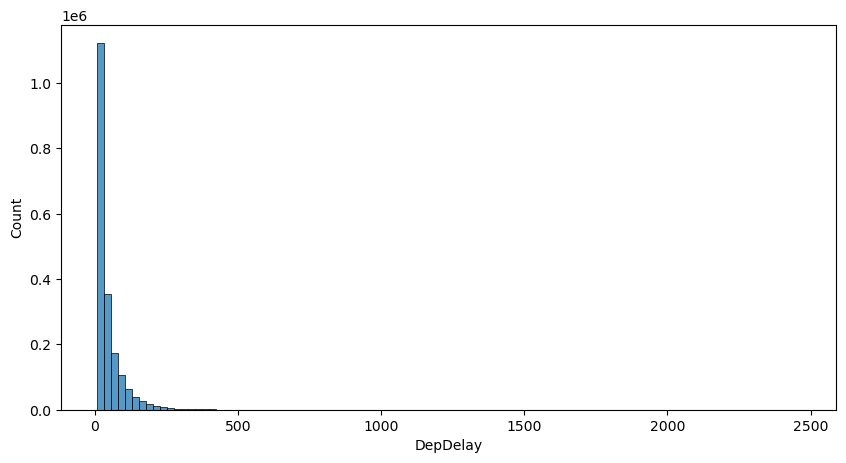

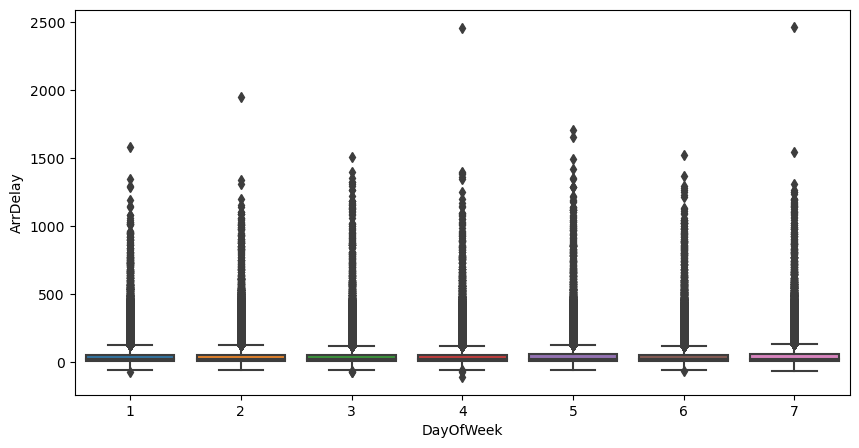

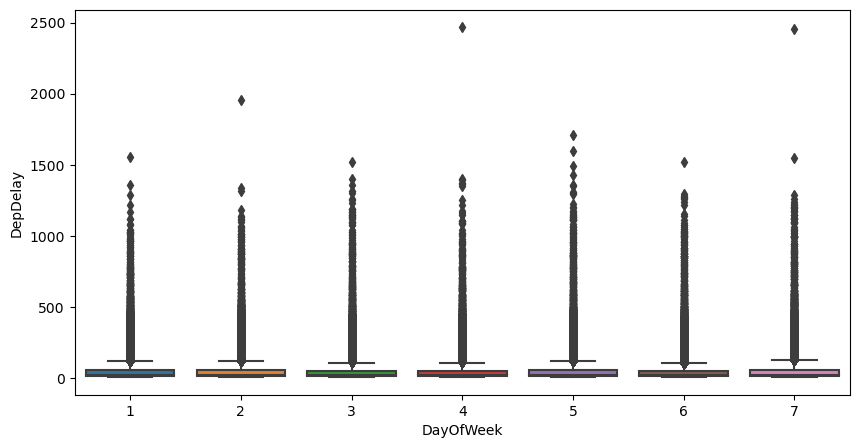

In [12]:
# histograma de la variable 'ArrDelay'
plt.figure(figsize=(10,5))
sns.histplot(df['ArrDelay'], kde=False, bins=100)

# histograma de la variable 'DepDelay'
plt.figure(figsize=(10,5))
sns.histplot(df['DepDelay'].dropna(), kde=False, bins=100)

# boxplot de la variable 'ArrDelay' por día de la semana
plt.figure(figsize=(10,5))
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df)

# boxplot de la variable 'DepDelay' por día de la semana
plt.figure(figsize=(10,5))
sns.boxplot(x='DayOfWeek', y='DepDelay', data=df)


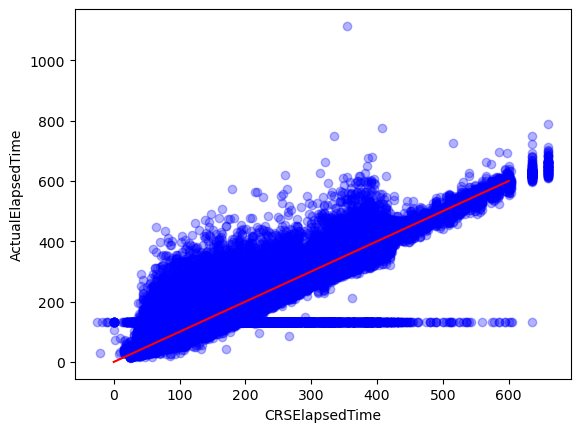

In [13]:
plt.scatter(df['CRSElapsedTime'], df['ActualElapsedTime'], alpha=0.3, color='blue')
plt.plot([0, 600], [0, 600], color='red')
plt.xlabel('CRSElapsedTime')
plt.ylabel('ActualElapsedTime')
plt.show()

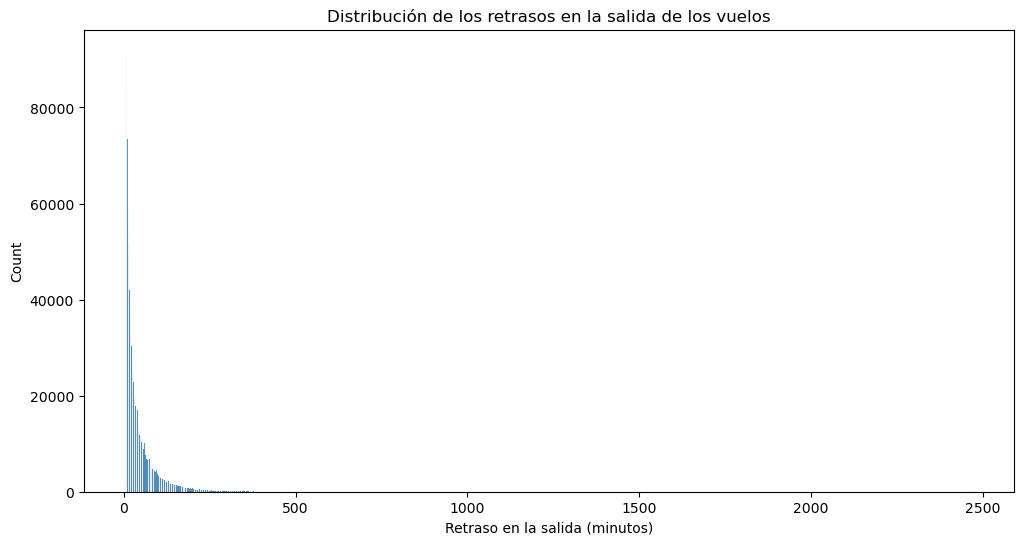

In [14]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="DepDelay")
plt.title("Distribución de los retrasos en la salida de los vuelos")
plt.xlabel("Retraso en la salida (minutos)")
plt.show()

El gráfico muestra que la mayoría de los retrasos son de menos de 100 minutos y que la frecuencia disminuye a medida que aumenta el retraso.

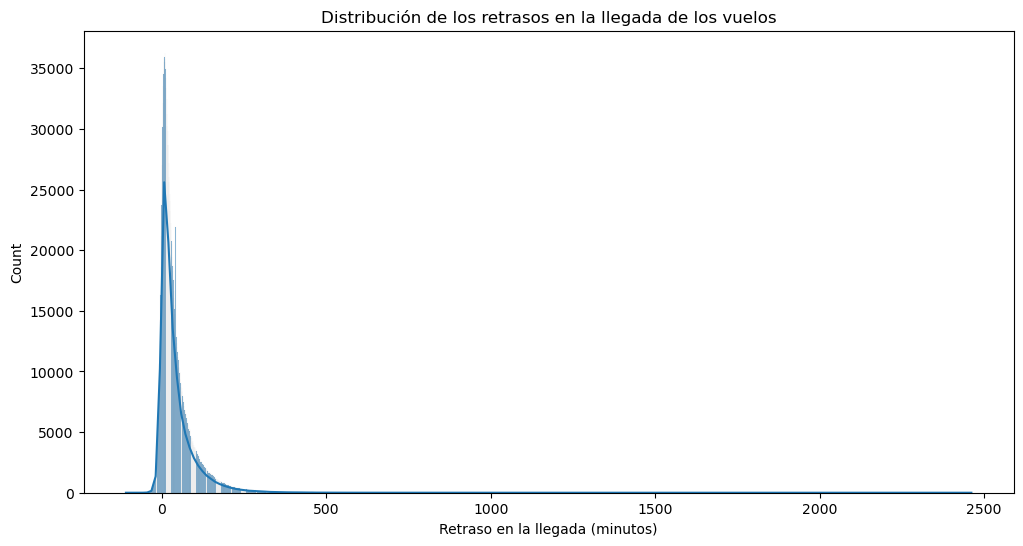

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="ArrDelay", kde=True)
plt.title("Distribución de los retrasos en la llegada de los vuelos")
plt.xlabel("Retraso en la llegada (minutos)")
plt.show()

El gráfico muestra una distribución similar a la anterior, con la mayoría de los retrasos siendo de menos de 100 minutos.

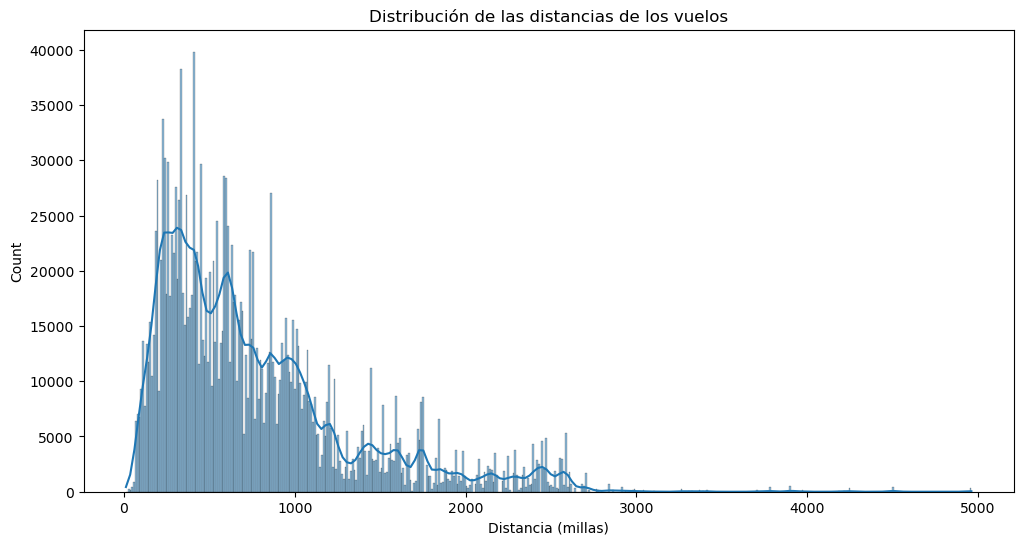

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="Distance", kde=True)
plt.title("Distribución de las distancias de los vuelos")
plt.xlabel("Distancia (millas)")
plt.show()

In [17]:
for dataset in df:
    df.loc[df['ArrDelay'] <= 15, 'Status'] = 0
    df.loc[df['ArrDelay'] >= 15, 'Status'] = 1
    df.loc[df['ArrDelay'] >= 60, 'Status'] = 2
    df.loc[df['Diverted'] == 1, 'Status'] = 3
    df.loc[df['Cancelled'] == 1, 'Status'] = 4

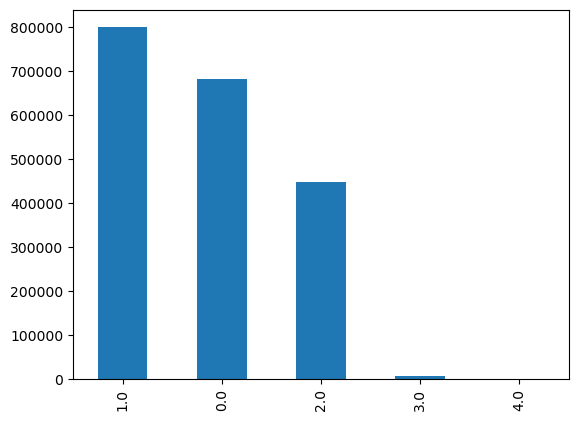

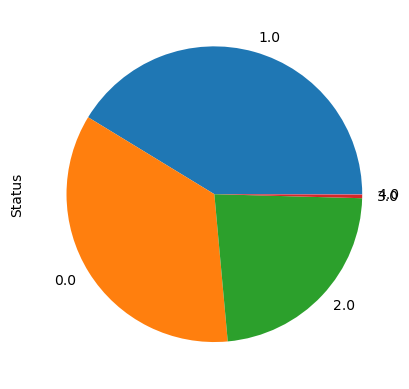

Status representa si el vuelo llegó a tiempo (0), ligeramente retrasado (1), muy retrasado (2), desviado (3) o cancelado (4)


In [18]:
df['Status'].value_counts().plot.bar()
plt.show()
df['Status'].value_counts().plot.pie()
plt.show()
print('Status representa si el vuelo llegó a tiempo (0), ligeramente retrasado (1), muy retrasado (2), desviado (3) o cancelado (4)')

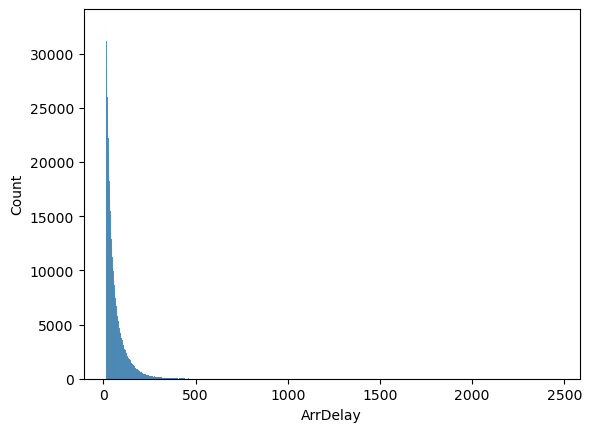

In [19]:
Delayedflights = df[(df.Status >= 1) &(df.Status < 3)]
#histogram
sns.histplot(Delayedflights['ArrDelay'])
plt.show()

La mayoría de los retrasos son cortos, y los retrasos más largos, aunque inusuales, tienen una mayor carga de tiempo.

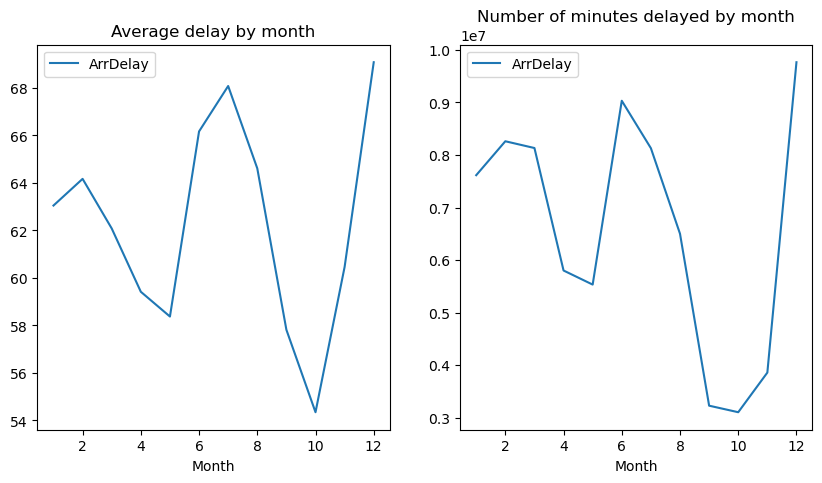

In [20]:
f,ax=plt.subplots(1,2,figsize=(10,5))
Delayedflights[['Month','ArrDelay']].groupby(['Month']).mean().plot(ax=ax[0])
ax[0].set_title('Average delay by month')
Delayedflights[['Month','ArrDelay']].groupby(['Month']).sum().plot(ax=ax[1])
ax[1].set_title('Number of minutes delayed by month')
plt.show()

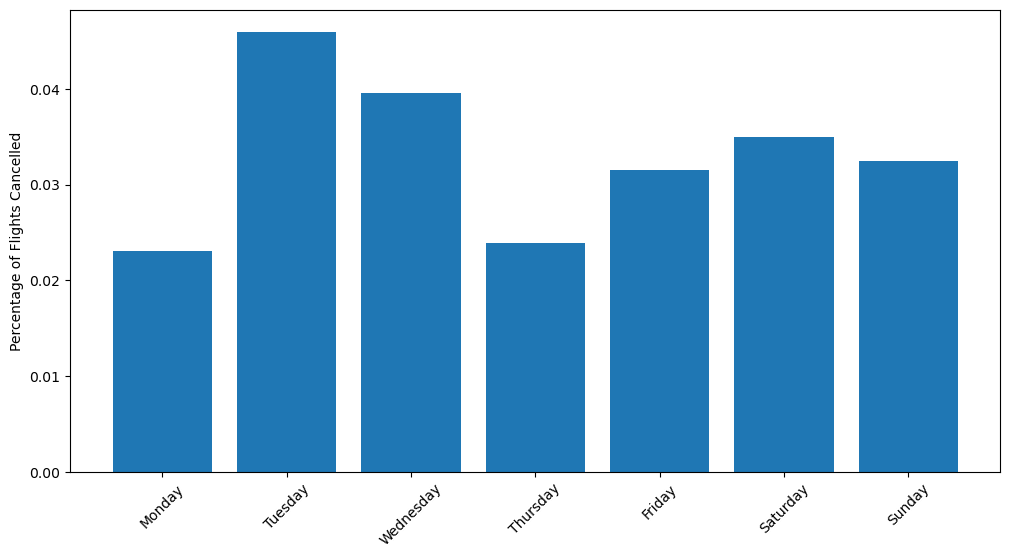

In [21]:

cancelled = df[df['Cancelled']==1]

days_cancelled = cancelled['Cancelled'].groupby(df['DayOfWeek']).count()
days_total = df['Cancelled'].groupby(df['DayOfWeek']).count()
days_frac = np.divide(days_cancelled, days_total)
x=days_frac.index.values
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize = (12,6))
ax.bar(x,days_frac*100, align='center')
ax.set_ylabel('Percentage of Flights Cancelled')
ax.set_xticks(x)
ax.set_xticklabels(week, rotation = 45)

plt.show()

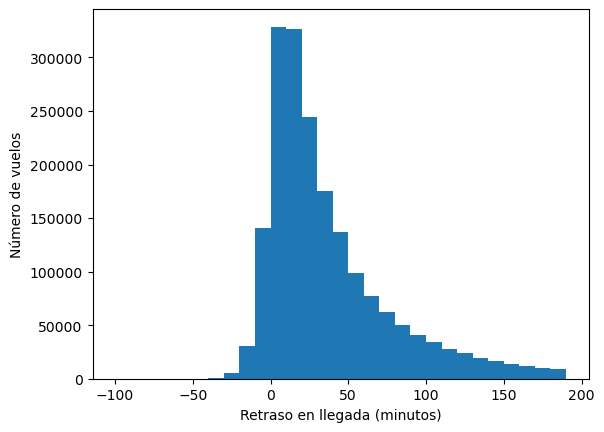

In [22]:
plt.hist(df['ArrDelay'], bins=range(-100, 200, 10))
plt.xlabel('Retraso en llegada (minutos)')
plt.ylabel('Número de vuelos')
plt.show()

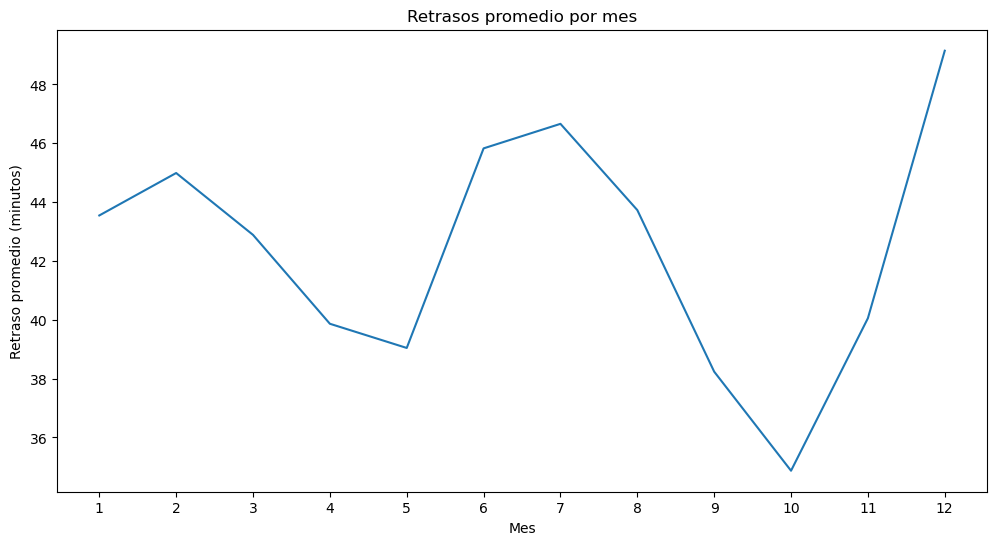

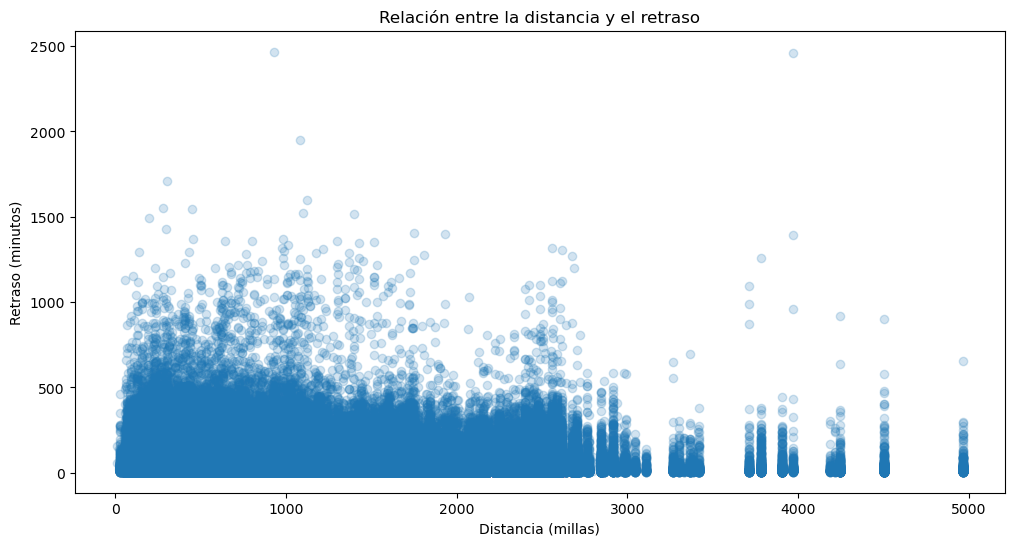

In [23]:
# crear un gráfico de línea para ver los retrasos promedio por mes
plt.figure(figsize=(12, 6))
df.groupby('Month')['DepDelay'].mean().plot(kind='line')
plt.title('Retrasos promedio por mes')
plt.xlabel('Mes')
plt.ylabel('Retraso promedio (minutos)')
plt.xticks(range(1, 13))
plt.show()

# crear un gráfico de dispersión para ver la relación entre la distancia y el retraso
plt.figure(figsize=(12, 6))
plt.scatter(df['Distance'], df['DepDelay'], alpha=0.2)
plt.title('Relación entre la distancia y el retraso')
plt.xlabel('Distancia (millas)')
plt.ylabel('Retraso (minutos)')
plt.show()

# Model Building

### Modelos de Regresión Multiple

In [24]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns

In [25]:
# Calculando la variable cost_per_mile
df['total_delay'] = df['CarrierDelay'] + df['WeatherDelay'] + df['NASDelay'] + df['SecurityDelay'] + df['LateAircraftDelay']
df['total_travel_time'] = df['AirTime'] + df['total_delay']
df['total_cost'] = df['total_travel_time'] * 50 + df['Distance'] * 0.1
df['cost'] = df['total_cost'] / df['Distance']


In [26]:
from sklearn import preprocessing
Num_features=df.select_dtypes(include=[np.number]).columns
df[Num_features]=preprocessing.MinMaxScaler().fit_transform(df[Num_features])
df.head()
df[Num_features]

,Year,Month,Day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Status,total_delay,total_travel_time,total_cost,cost
0,0.0,0.0,0.066667,0.500000,0.834514,0.828741,0.921217,0.927083,0.034288,0.103636,...,0.000821,0.00000,0.000000,0.0,0.024316,0.00,0.007768,0.046495,0.046313,0.008076
1,0.0,0.0,0.066667,0.500000,0.313881,0.311573,0.417257,0.416667,0.331588,0.103636,...,0.000821,0.00000,0.000000,0.0,0.024316,0.00,0.007768,0.045455,0.045274,0.007898
2,0.0,0.0,0.066667,0.500000,0.261359,0.262823,0.334723,0.312500,0.045889,0.074545,...,0.000821,0.00000,0.000000,0.0,0.024316,0.00,0.007768,0.032616,0.032259,0.009442
3,0.0,0.0,0.066667,0.500000,0.761984,0.743959,0.816173,0.802083,0.402320,0.069091,...,0.000821,0.00000,0.000000,0.0,0.024316,0.25,0.007768,0.032963,0.032605,0.009535
4,0.0,0.0,0.066667,0.500000,0.808253,0.811785,0.883702,0.879167,0.038702,0.079091,...,0.002463,0.00000,0.000000,0.0,0.030015,0.00,0.012469,0.040423,0.040169,0.008432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,0.0,1.0,0.400000,0.833333,0.520634,0.517168,0.673614,0.646667,0.166307,0.120909,...,0.001232,0.00000,0.000000,0.0,0.016717,0.25,0.004088,0.044761,0.044648,0.006868
1936754,0.0,1.0,0.400000,0.833333,0.273447,0.254345,0.376407,0.312083,0.167334,0.102727,...,0.000000,0.04216,0.013265,0.0,0.000000,0.50,0.024530,0.047536,0.047124,0.014464
1936755,0.0,1.0,0.400000,0.833333,0.419341,0.359050,0.478533,0.420833,0.167334,0.134545,...,0.000411,0.00000,0.014001,0.0,0.060030,0.50,0.034342,0.071131,0.070813,0.014593
1936756,0.0,1.0,0.400000,0.833333,0.521050,0.525646,0.602334,0.598750,0.168155,0.091818,...,0.000411,0.00000,0.014001,0.0,0.060030,0.00,0.034342,0.059681,0.059279,0.016129


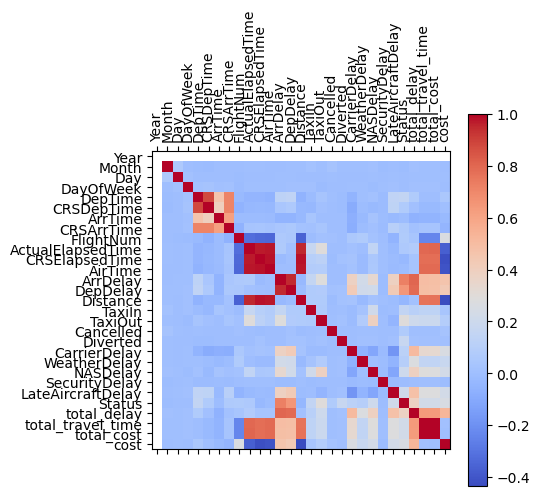

In [27]:
# Calcular la correlación entre las columnas numéricas
corr_matrix = df[Num_features].corr()
# Visualizar la matriz de correlación como un mapa de calor
plt.matshow(corr_matrix, cmap='coolwarm')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()
plt.show()

#### Modelo 1 

Modelo con variable dependiente 'cost'

In [28]:
# construir el modelo
df.drop(columns=['Day', 'Month', 'Year','TailNum'])
X = df[Num_features].drop(columns = 'cost')
y = df['cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# MLR
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                 6.371e+04
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:52:54   Log-Likelihood:             5.2983e+06
No. Observations:             1549406   AIC:                        -1.060e+07
Df Residuals:                 1549381   BIC:                        -1.060e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0170      0.00

Eliminar ruido de variables en el modelo 

In [29]:
# inicializar el modelo de regresión lineal
lr = LinearRegression()

# inicializar el objeto RFE
rfe = RFE(lr, n_features_to_select=8)

# ajustar el objeto RFE al conjunto de entrenamiento
rfe.fit(X_train, y_train)
# imprimir las variables seleccionadas
print('Variables seleccionadas:', X.columns[rfe.support_])

# ajustar el modelo de regresión lineal al conjunto de entrenamiento
lr.fit(X_train.loc[:, rfe.support_], y_train)
y_pred = lr.predict(X_test.loc[:, rfe.support_])
# imprimir el coeficiente de determinación del modelo ajustado
print('R^2:', lr.score(X_test.loc[:, rfe.support_], y_test))

Variables seleccionadas: Index(['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'LateAircraftDelay', 'total_delay', 'total_travel_time', 'total_cost'],
      dtype='object')
R^2: 0.4760729832045093


Modelo con el ruido ya eliminado

In [30]:
var_rfe = ['ActualElapsedTime', 'CRSElapsedTime', 'TaxiOut', 'Cancelled',
       'Diverted', 'WeatherDelay', 'NASDelay', 'total_delay']
# construir el modelo
X = df[var_rfe]
y = df['cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_re = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
# print(model_re.summary())
# calcular el VIF para cada variable
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# imprimir los resultados
print(vif)

            features  VIF Factor
0  ActualElapsedTime   40.279160
1     CRSElapsedTime   39.316267
2            TaxiOut    2.912236
3          Cancelled    1.000365
4           Diverted    1.011765
5       WeatherDelay    1.129543
6           NASDelay    1.685619
7        total_delay    2.126471


In [31]:
var_final_1 = ['ActualElapsedTime','TaxiOut', 'Cancelled',
       'Diverted', 'WeatherDelay', 'NASDelay', 'total_delay']
# construir el modelo
X = df[var_final_1]
y = df['cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model_1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
summary_final_1 = final_model_1.summary()
# calcular el VIF para cada variable
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# imprimir los resultados
print(vif)
print("Valor AIC del modelo: ", final_model_1.aic)


            features  VIF Factor
0  ActualElapsedTime    2.568150
1            TaxiOut    2.907186
2          Cancelled    1.000356
3           Diverted    1.004086
4       WeatherDelay    1.127156
5           NASDelay    1.601930
6        total_delay    1.981189
Valor AIC del modelo:  -10500413.179554375


KS Statistic: 0.4899658050114269


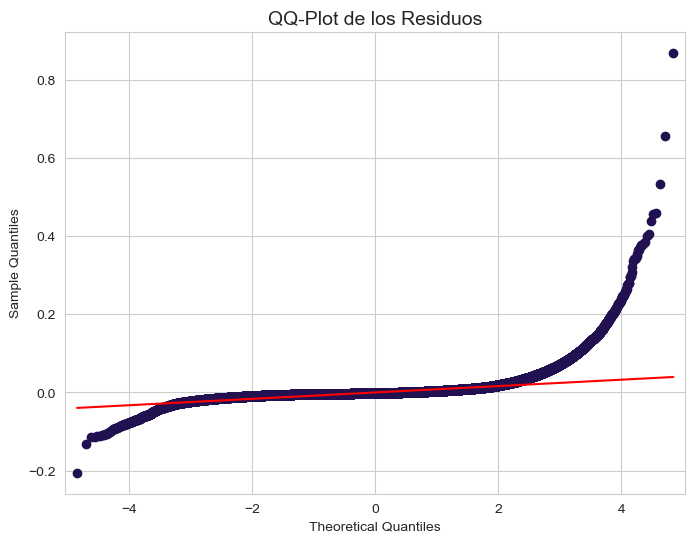

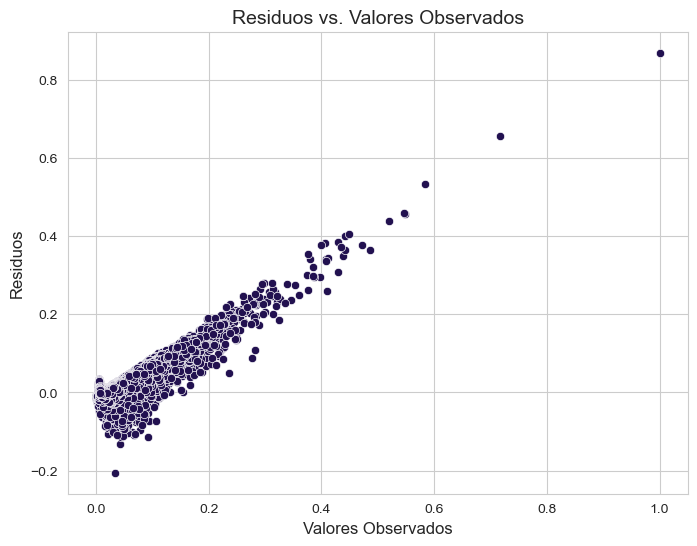

In [32]:

# Obtener residuos
residuos = final_model_1.resid

# Realizar prueba de Kolmogorov-Smirnov para verificar normalidad
ks_stat, p_value = stats.kstest(residuos, 'norm')
print('KS Statistic:', ks_stat)

# Graficar QQ-plot de los residuos
sns.set_style("whitegrid")
sns.set_palette("magma")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
qqplot(residuos, line='s', ax=ax)
ax.set_title("QQ-Plot de los Residuos", fontsize=14)
plt.show()

# Graficar valores observados vs residuos
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")
sns.set_palette("Reds")
sns.scatterplot(x=y_train, y=residuos, ax=ax)
ax.set_xlabel('Valores Observados', fontsize=12)
ax.set_ylabel('Residuos', fontsize=12)
ax.set_title('Residuos vs. Valores Observados', fontsize=14)
plt.show()

#### Modelo 2 

Modelo con variable dependiente 'ArrDelay'

In [34]:
# construir el modelo
df.drop(columns=['Day', 'Month', 'Year','TailNum'])
X = df[Num_features].drop(columns = 'ArrDelay')
y = df['ArrDelay']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 4.306e+06
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:58:08   Log-Likelihood:             6.9785e+06
No. Observations:             1549406   AIC:                        -1.396e+07
Df Residuals:                 1549381   BIC:                        -1.396e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0536   2.71e-0

In [35]:
# inicializar el modelo de regresión lineal
lr = LinearRegression()

# inicializar el objeto RFE
rfe = RFE(lr, n_features_to_select=5)

# ajustar el objeto RFE al conjunto de entrenamiento
rfe.fit(X_train, y_train)
# imprimir las variables seleccionadas
print('Variables seleccionadas:', X.columns[rfe.support_])

# ajustar el modelo de regresión lineal al conjunto de entrenamiento
lr.fit(X_train.loc[:, rfe.support_], y_train)
y_pred = lr.predict(X_test.loc[:, rfe.support_])
# imprimir el coeficiente de determinación del modelo ajustado
print('R^2:', lr.score(X_test.loc[:, rfe.support_], y_test))

Variables seleccionadas: Index(['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'DepDelay',
       'total_delay'],
      dtype='object')
R^2: 0.9832857687355299


In [46]:
var_final_2 = ['ActualElapsedTime','DepDelay', 'Cancelled','Diverted']
# construir el modelo
X = df[var_final_2]
y = df['ArrDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model_2 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
summary_final_2 = final_model_2.summary()
# calcular el VIF para cada variable
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# imprimir los resultados
print(vif)
print("Valor AIC del modelo: ", final_model_2.aic)


            features  VIF Factor
0  ActualElapsedTime    1.329852
1           DepDelay    1.330401
2          Cancelled    1.000622
3           Diverted    1.003962
Valor AIC del modelo:  -11032696.674668388


KS Statistic: 0.4905182642780004


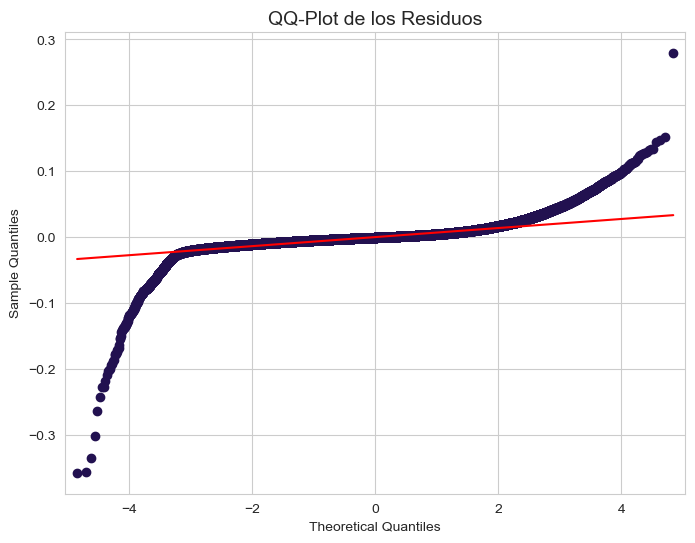

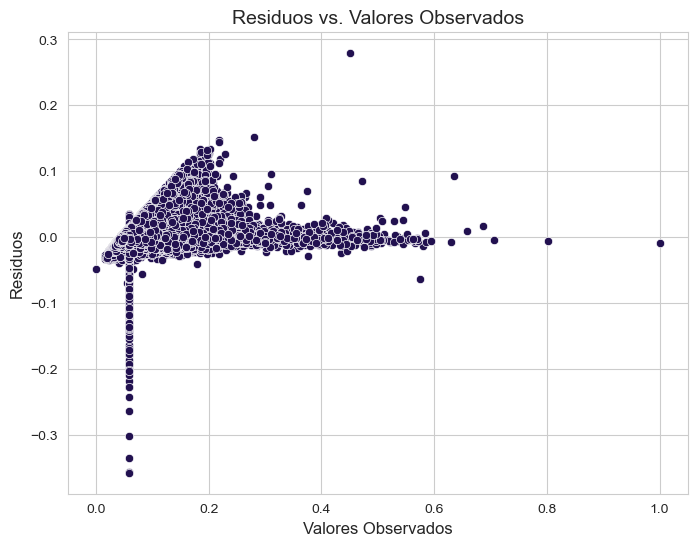

In [37]:

# Obtener residuos
residuos = final_model_2.resid

# Realizar prueba de Kolmogorov-Smirnov para verificar normalidad
ks_stat, p_value = stats.kstest(residuos, 'norm')
print('KS Statistic:', ks_stat)

# Graficar QQ-plot de los residuos
sns.set_style("whitegrid")
sns.set_palette("magma")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
qqplot(residuos, line='s', ax=ax)
ax.set_title("QQ-Plot de los Residuos", fontsize=14)
plt.show()

# Graficar valores observados vs residuos
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")
sns.set_palette("Reds")
sns.scatterplot(x=y_train, y=residuos, ax=ax)
ax.set_xlabel('Valores Observados', fontsize=12)
ax.set_ylabel('Residuos', fontsize=12)
ax.set_title('Residuos vs. Valores Observados', fontsize=14)
plt.show()

#### Modelo 3 

In [38]:
# construir el modelo
df.drop(columns=['Day', 'Month', 'Year','TailNum'])
X = df[Num_features].drop(columns = ['Distance', 'total_cost'])
y = df['Distance']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model3 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 2.241e+06
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:00:03   Log-Likelihood:             3.9081e+06
No. Observations:             1549406   AIC:                        -7.816e+06
Df Residuals:                 1549381   BIC:                        -7.816e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0978      0.00

In [ ]:
# inicializar el modelo de regresión lineal
lr = LinearRegression()

# inicializar el objeto RFE
rfe = RFE(lr, n_features_to_select=5)

# ajustar el objeto RFE al conjunto de entrenamiento
rfe.fit(X_train, y_train)
# imprimir las variables seleccionadas
print('Variables seleccionadas:', X.columns[rfe.support_])

# ajustar el modelo de regresión lineal al conjunto de entrenamiento
lr.fit(X_train.loc[:, rfe.support_], y_train)
y_pred = lr.predict(X_test.loc[:, rfe.support_])
# imprimir el coeficiente de determinación del modelo ajustado
print('R^2:', lr.score(X_test.loc[:, rfe.support_], y_test))

In [40]:
var_rfe = ['AirTime', 'CarrierDelay', 'SecurityDelay', 'LateAircraftDelay','total_travel_time']
# construir el modelo
X = df[var_rfe]
y = df['Distance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_re = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
# print(model_re.summary())
# calcular el VIF para cada variable
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# imprimir los resultados
print(vif)

            features  VIF Factor
0            AirTime   16.168791
1       CarrierDelay    2.384137
2      SecurityDelay    1.003723
3  LateAircraftDelay    2.543129
4  total_travel_time   25.515949


In [41]:
var_s_AT = ['CarrierDelay', 'SecurityDelay', 'LateAircraftDelay','total_travel_time']
# construir el modelo
X = df[var_s_AT]
y = df['Distance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_s_AT = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
print(model_s_AT.summary())
# calcular el VIF para cada variable
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# imprimir los resultados
print(vif)
print("Valor AIC del modelo: ", model_s_AT.aic)

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 1.107e+06
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:01:01   Log-Likelihood:             2.1841e+06
No. Observations:             1549406   AIC:                        -4.368e+06
Df Residuals:                 1549401   BIC:                        -4.368e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0037   9.45e-0

In [42]:
var_s_TT = ['AirTime', 'CarrierDelay', 'SecurityDelay', 'LateAircraftDelay']
# construir el modelo
X = df[var_s_TT]
y = df['Distance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_s_TT = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
print(model_s_TT.summary())
# calcular el VIF para cada variable
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# imprimir los resultados
print(vif)
print("Valor AIC del modelo: ", model_s_TT.aic)

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 8.225e+06
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:01:06   Log-Likelihood:             3.5410e+06
No. Observations:             1549406   AIC:                        -7.082e+06
Df Residuals:                 1549401   BIC:                        -7.082e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0279   4.09e-0

In [47]:
var_final_3 = ['AirTime', 'CarrierDelay', 'SecurityDelay', 'LateAircraftDelay']
# construir el modelo
X = df[var_final_3]
y = df['Distance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model_3 = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# imprimir el resumen del modelo
summary_final_3 = final_model_3.summary()
# calcular el VIF para cada variable
vif = pd.DataFrame()
vif["features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# imprimir los resultados
print(vif)
print("Valor AIC del modelo: ", final_model_3.aic)


            features  VIF Factor
0            AirTime    1.461531
1       CarrierDelay    1.174205
2      SecurityDelay    1.002430
3  LateAircraftDelay    1.263708
Valor AIC del modelo:  -7081890.176819073


KS Statistic: 0.46354336884483516


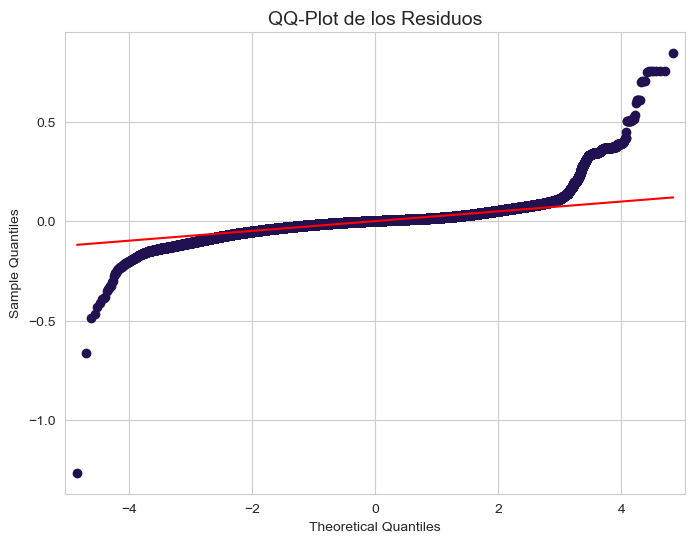

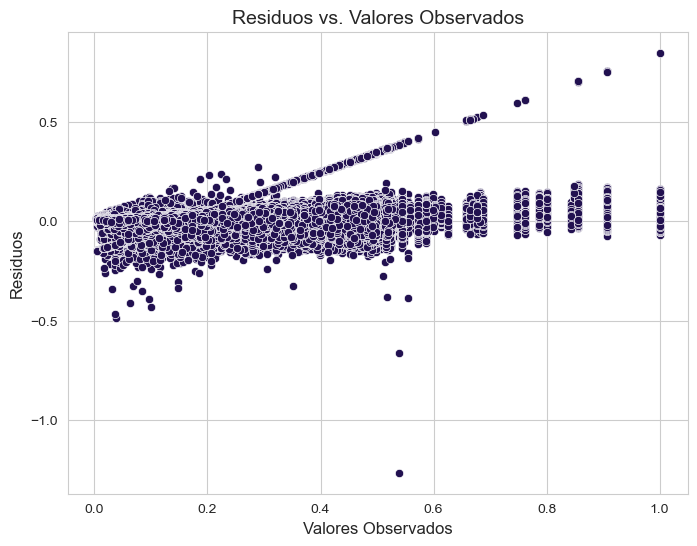

In [44]:

# Obtener residuos
residuos = final_model_3.resid

# Realizar prueba de Kolmogorov-Smirnov para verificar normalidad
ks_stat, p_value = stats.kstest(residuos, 'norm')
print('KS Statistic:', ks_stat)

# Graficar QQ-plot de los residuos
sns.set_style("whitegrid")
sns.set_palette("magma")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
qqplot(residuos, line='s', ax=ax)
ax.set_title("QQ-Plot de los Residuos", fontsize=14)
plt.show()

# Graficar valores observados vs residuos
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")
sns.set_palette("Reds")
sns.scatterplot(x=y_train, y=residuos, ax=ax)
ax.set_xlabel('Valores Observados', fontsize=12)
ax.set_ylabel('Residuos', fontsize=12)
ax.set_title('Residuos vs. Valores Observados', fontsize=14)
plt.show()

### Modelo de Red Neuronal

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import StandardScaler


In [23]:
# Dividir en datos de entrenamiento y prueba
X = df[Num_features]
y = df['Distance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear conjunto de datos de TensorFlow
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Definir modelo de red neuronal
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compilar modelo
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])

# Entrenar modelo
history = model.fit(train_data.shuffle(1000).batch(128), epochs=100, validation_data=test_data.batch(128))

# Graficar pérdida y precisión del modelo durante el entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)


Epoch 1/100
12105/12105 [==============================] - 26s 2ms/step - loss: 6.3687e-04 - mae: 0.0090 - val_loss: 3.8608e-06 - val_mae: 0.0011
Epoch 2/100
12105/12105 [==============================] - 28s 2ms/step - loss: 3.9984e-06 - mae: 9.2666e-04 - val_loss: 8.6304e-07 - val_mae: 5.5965e-04
Epoch 3/100
12105/12105 [==============================] - 28s 2ms/step - loss: 1.6548e-06 - mae: 5.9891e-04 - val_loss: 3.4934e-07 - val_mae: 2.7172e-04
Epoch 4/100
12105/12105 [==============================] - 30s 2ms/step - loss: 9.5635e-07 - mae: 4.6654e-04 - val_loss: 4.5092e-07 - val_mae: 4.5297e-04
Epoch 5/100
12105/12105 [==============================] - 29s 2ms/step - loss: 7.9807e-07 - mae: 4.1243e-04 - val_loss: 4.7380e-07 - val_mae: 2.9614e-04
Epoch 6/100
12105/12105 [==============================] - 29s 2ms/step - loss: 5.8737e-07 - mae: 3.5159e-04 - val_loss: 2.4315e-07 - val_mae: 2.2401e-04
Epoch 7/100
12105/12105 [==============================] - 29s 2ms/step - loss: 5.55

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

### Interfaz Grafica

In [ ]:
import tkinter as tk
from tkinter import ttk
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure


root = tk.Tk()
root.title("Airlines Study")
root.geometry("1000x900")

background_image = tk.PhotoImage(file="mapaNet.png")
background_label = tk.Label(root, image=background_image)
background_label.place(x=0, y=0, relwidth=1, relheight=1)

selected_option = tk.StringVar()
selected_graph = None

option_frame = ttk.Frame(root, padding=(20, 10))
option_frame.pack(fill="both")

eda_option = ttk.Radiobutton(option_frame, text="EDA", variable=selected_option, value="eda")
eda_option.grid(row=0, column=0, padx=10, pady=5)

mlr_option = ttk.Radiobutton(option_frame, text="MLR", variable=selected_option, value="mlr")
mlr_option.grid(row=0, column=1, padx=10, pady=5)

nn_option = ttk.Radiobutton(option_frame, text="Modelo de redes neuronales", variable=selected_option, value="nn")
nn_option.grid(row=0, column=2, padx=10, pady=5)

def generate_eda_graph_1():
    # Código para generar el primer gráfico de EDA
    print("Generando Gráfico 1 de EDA...")
    # Calcular la correlación entre las columnas numéricas
    corr_matrix = df[numeric_cols].corr()
    # Visualizar la matriz de correlación como un mapa de calor
    plt.matshow(corr_matrix, cmap='coolwarm')
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.colorbar()
    plt.show()

def generate_eda_graph_2():
    # Código para generar el segundo gráfico de EDA
    print("Generando Gráfico 2 de EDA...")
    # análisis de la variable 'UniqueCarrier'
    plt.figure(figsize=(10,5))
    sns.countplot(x='UniqueCarrier', data=df, order=df['UniqueCarrier'].value_counts().index)

    # análisis de la variable 'Origin'
    plt.figure(figsize=(15,5))
    sns.countplot(x='Origin', data=df, order=df['Origin'].value_counts().index)

    # análisis de la variable 'Dest'
    plt.figure(figsize=(15,5))
    sns.countplot(x='Dest', data=df, order=df['Dest'].value_counts().index)

def generate_eda_graph_3():
    # Código para generar el tercer gráfico de EDA
    print("Generando Gráfico 3 de EDA...")
    # histograma de la variable 'ArrDelay'
    plt.figure(figsize=(10,5))
    sns.histplot(df['ArrDelay'].dropna(), kde=False, bins=100)

    # histograma de la variable 'DepDelay'
    plt.figure(figsize=(10,5))
    sns.histplot(df['DepDelay'].dropna(), kde=False, bins=100)

    # boxplot de la variable 'ArrDelay' por día de la semana
    plt.figure(figsize=(10,5))
    sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df)

    # boxplot de la variable 'DepDelay' por día de la semana
    plt.figure(figsize=(10,5))
    sns.boxplot(x='DayOfWeek', y='DepDelay', data=df)

    # matriz de correlación de las variables numéricas
    corr = df[['DepDelay', 'ArrDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].corr()
    plt.figure(figsize=(10,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm')


def generate_eda_graph_4():
    plt.scatter(df['CRSElapsedTime'], df['ActualElapsedTime'], alpha=0.3, color='blue')
    plt.plot([0, 600], [0, 600], color='red')
    plt.xlabel('CRSElapsedTime')
    plt.ylabel('ActualElapsedTime')
    plt.show()

def generate_eda_graph_5():
    plt.figure(figsize=(12,6))
    sns.histplot(data=df, x="Distance", kde=True)
    plt.title("Distribución de las distancias de los vuelos")
    plt.xlabel("Distancia (millas)")
    plt.show()

def generate_eda_graph_6():
    for dataset in df:
        df.loc[df['ArrDelay'] <= 15, 'Status'] = 0
        df.loc[df['ArrDelay'] >= 15, 'Status'] = 1
        df.loc[df['ArrDelay'] >= 60, 'Status'] = 2
        df.loc[df['Diverted'] == 1, 'Status'] = 3
        df.loc[df['Cancelled'] == 1, 'Status'] = 4


    df['Status'].value_counts().plot.bar()
    plt.show()
    df['Status'].value_counts().plot.pie()
    plt.show()
    print('Status representa si el vuelo llegó a tiempo (0), ligeramente retrasado (1), muy retrasado (2), desviado (3) o cancelado (4)')

def generate_eda_graph_7():
    Delayedflights = df[(df.Status >= 1) &(df.Status < 3)]
    #histogram
    sns.histplot(Delayedflights['ArrDelay'])
    plt.show()

def generate_eda_graph_8():
    fig, ax = plt.subplots(figsize = (12,6))
    ax.bar(x,days_frac*100, align='center')
    ax.set_ylabel('Percentage of Flights Cancelled')
    ax.set_xticks(x)
    ax.set_xticklabels(week, rotation = 45)

def generate_M1_graph():
    # Código para generar el gráfico de MLR
    # crear un dataframe con el resumen del modelo
    summary_df = pd.read_html(summary_final_1.tables[1].as_html(), header=0, index_col=0)[0]
    # Obtener residuos
    residuos = final_model_1.resid

    # crear un gráfico de barras horizontales con los coeficientes del modelo
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(summary_df.index, summary_df['coef'], color='blue')
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.set_title('Resumen del modelo de regresión lineal múltiple')
    ax.set_xlabel('Coeficiente')
    ax.set_ylabel('Variable')

    # Graficar QQ-plot de los residuos
    sns.set_style("whitegrid")
    sns.set_palette("magma")
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    qqplot(residuos, line='s', ax=ax)
    ax.set_title("QQ-Plot de los Residuos", fontsize=14)

    # Graficar valores observados vs residuos
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.set_palette("magma")
    sns.scatterplot(x=y_train, y=residuos, ax=ax)
    ax.set_xlabel('Valores Observados', fontsize=12)
    ax.set_ylabel('Residuos', fontsize=12)
    ax.set_title('Residuos vs. Valores Observados', fontsize=14)
    plt.show()

def generate_M2_graph():
    # Código para generar el gráfico de MLR
    # crear un dataframe con el resumen del modelo
    summary_df = pd.read_html(summary_final_2.tables[1].as_html(), header=0, index_col=0)[0]
    # Obtener residuos
    residuos = final_model_2.resid

    # crear un gráfico de barras horizontales con los coeficientes del modelo
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(summary_df.index, summary_df['coef'], color='blue')
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.set_title('Resumen del modelo de regresión lineal múltiple')
    ax.set_xlabel('Coeficiente')
    ax.set_ylabel('Variable')

    # Graficar QQ-plot de los residuos
    sns.set_style("whitegrid")
    sns.set_palette("magma")
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    qqplot(residuos, line='s', ax=ax)
    ax.set_title("QQ-Plot de los Residuos", fontsize=14)

    # Graficar valores observados vs residuos
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.set_palette("magma")
    sns.scatterplot(x=y_train, y=residuos, ax=ax)
    ax.set_xlabel('Valores Observados', fontsize=12)
    ax.set_ylabel('Residuos', fontsize=12)
    ax.set_title('Residuos vs. Valores Observados', fontsize=14)
    plt.show()

def generate_M3_graph():
    # Código para generar el gráfico de MLR
    # crear un dataframe con el resumen del modelo
    summary_df = pd.read_html(summary_final_3.tables[1].as_html(), header=0, index_col=0)[0]
    # Obtener residuos
    residuos = final_model_3.resid

    # crear un gráfico de barras horizontales con los coeficientes del modelo
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(summary_df.index, summary_df['coef'], color='blue')
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.set_title('Resumen del modelo de regresión lineal múltiple')
    ax.set_xlabel('Coeficiente')
    ax.set_ylabel('Variable')

    # Graficar QQ-plot de los residuos
    sns.set_style("whitegrid")
    sns.set_palette("magma")
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    qqplot(residuos, line='s', ax=ax)
    ax.set_title("QQ-Plot de los Residuos", fontsize=14)

    # Graficar valores observados vs residuos
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.set_palette("magma")
    sns.scatterplot(x=y_train, y=residuos, ax=ax)
    ax.set_xlabel('Valores Observados', fontsize=12)
    ax.set_ylabel('Residuos', fontsize=12)
    ax.set_title('Residuos vs. Valores Observados', fontsize=14)
    plt.show()


def generate_nn_graph():
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.show()


def option_selected():
    option = selected_option.get()
    if option == "eda":
        # Crear un segundo marco para las opciones de gráfico de EDA
        graph_frame = ttk.Frame(root, padding=(20, 10))
        graph_frame.pack(fill="both")
        
        # Crear un Combobox para las opciones de gráfico de EDA
        graph_options = ["G1", "G2 ", "G3", "G4", "G5", "G6", "G7", "G8"]
        selected_graph_option = tk.StringVar()
        graph_selector = ttk.Combobox(graph_frame, textvariable=selected_graph_option, values=graph_options)
        graph_selector.grid(row=0, column=0, padx=10, pady=5)
        
        # Crear una función que genere el gráfico seleccionado
        def generate_graph():
            graph = selected_graph_option.get()
            if graph == "G1":
                generate_eda_graph_1()
            elif graph == "G2":
                generate_eda_graph_2()
            elif graph == "G3":
                generate_eda_graph_3()
            elif graph == "G4":
                generate_eda_graph_4()
            elif graph == "G5":
                generate_eda_graph_5()
            elif graph == "G6":
                generate_eda_graph_6()
            elif graph == "G7":
                generate_eda_graph_7()
            elif graph == "G8":
                generate_eda_graph_8()
        
        # Crear un botón para generar el gráfico seleccionado
        generate_button = ttk.Button(graph_frame, text="Generar gráfico", command=generate_graph)
        generate_button.grid(row=0, column=1, padx=10, pady=5)
        
    elif option == "mlr":
        # Crear un segundo marco para las opciones de gráfico de EDA
        graph_frame = ttk.Frame(root, padding=(20, 10))
        graph_frame.pack(fill="both")
        
        # Crear un Combobox para las opciones de gráfico de EDA
        graph_options = ["M1", "M2", "M3"]
        selected_graph_option = tk.StringVar()
        graph_selector = ttk.Combobox(graph_frame, textvariable=selected_graph_option, values=graph_options)
        graph_selector.grid(row=0, column=0, padx=10, pady=5)
        
        # Crear una función que genere el gráfico seleccionado
        def generate_graph_mlr():
            graph = selected_graph_option.get()
            if graph == "M1":
                generate_M1_graph()
            elif graph == "M2":
                generate_M2_graph()
            elif graph == "M3":
                genera_M3_graph()
        # Crear un botón para generar el gráfico seleccionado
        generate_button = ttk.Button(graph_frame, text="Generar gráfico", command=generate_graph_mlr)
        generate_button.grid(row=0, column=1, padx=10, pady=5)

    elif option == "nn":
        generate_nn_graph()

# Crear un botón para confirmar la opción seleccionada
confirm_button = ttk.Button(root, text="Confirmar", command=option_selected)
confirm_button.pack(pady=10)

root.mainloop()


In [ ]:
# # Crear el grafo
# G = nx.Graph()

# # Agregar nodos para cada ciudad
# for city in df['Origin'].unique():
#     city_df = df[df['Origin'] == city]
#     num_flights_out = len(city_df)
#     num_flights_in = len(df[df['Dest'] == city])
#     avg_distance = city_df['Distance'].mean()
#     avg_airtime = city_df['AirTime'].mean()
#     avg_arr_delay = city_df['ArrDelay'].mean()
#     carriers = city_df['UniqueCarrier'].unique()
#     destinations = city_df['Dest'].unique()
    
#     G.add_node(city,
#                num_flights_out=num_flights_out,
#                num_flights_in=num_flights_in,
#                avg_distance=avg_distance,
#                avg_airtime=avg_airtime,
#                avg_arr_delay=avg_arr_delay,
#                carriers=carriers,
#                destinations=destinations)

# # Agregar aristas para cada ruta
# for _, row in df.iterrows():
#     origin = row['Origin']
#     dest = row['Dest']
#     distance = row['Distance']
#     if not G.has_node(origin):
#         G.add_node(origin)
#     if not G.has_node(dest):
#         G.add_node(dest)
#     if not G.has_edge(origin, dest):
#         G.add_edge(origin, dest, weight=distance)

# # distance = nx.shortest_path_length(G, source='ATL', target='LAX', weight='weight')
# # print(f"La distancia entre ATL y LAX es {distance}.")

# # Dibujar el grafo
# nx.draw(G, with_labels=True)

# plt.annotate('Coeficiente de determinación: {:.2f}'.format(final_model_1.rsquared),
#              xy=(0.1, 0.9), xycoords='axes fraction')
# plt.annotate('Valor AIC: {:.2f}'.format(final_model_1.aic),
#              xy=(0.1, 0.85), xycoords='axes fraction')
# plt.show()